# Experiment: Business Process Drift - (Maaradji - Fast)

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pm4py
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from sklearn.model_selection import ParameterGrid

from tqdm.notebook import tqdm_notebook
import time
from matplotlib.backends.backend_pdf import PdfPages
from joblib import Parallel, delayed

sys.path.append("../Codes/")
import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(threshold=sys.maxsize)


## Function to run the class TMPD pipeline in parallel

In [9]:
def run_pipeline_TMPD(kwargs, display=False, return_bool=False):

    try:

        ### Loading event log
        # Extracting event log
        event_log = TMPD_utils.parse_mxml(kwargs['log_path'])

        # This is a specifc step for this event log that separates in different rows the start and end of an activity. As we will only use one timestamp, we are filtering only the row representing the end of an activity.  
        event_log = event_log[event_log.EventType == "complete"]

        # Save original event index
        event_log = event_log.reset_index(names='original_index') 

        # Create an id based on the order of the event in the raw event log
        event_log["Event_order_id"] = event_log.index

        # This is a specifc step for this event log, because it have duplicated case ids. So we create a new case id.
        event_log["Trace_order"] = TMPD_utils.cumulative_counting(event_log["CaseId"])

        # Showing loaded event log
        # event_log.head(15)


        ### Step 1 - Instantiating class and setting event log
        print('step 1')
        # Iniatializing the TMPD_class
        TMPD_instance = TMPD_class.TMPD(scenario='offline')

        # Setting the transition log
        TMPD_instance.set_transition_log(event_log, case_id = kwargs['case_id'], activity_key = kwargs['activity_key']
                                         , timestamp_key = kwargs['timestamp_key'], timestamp_format=kwargs['timestamp_format'], other_columns_keys=kwargs['other_columns_keys'])

        # Executing the transition log
        TMPD_instance.run_transition_log()

        # Showing the transition log created
        # TMPD_instance.get_transition_log().head(15)

        
        ### Step 2 - Setting Window Strategy
        print('step 2')
        # Setting the window strategy parameters
        TMPD_instance.set_windowing_strategy(window_size_mode = kwargs['window_size_mode'], window_size = kwargs['window_size'], window_ref_mode = kwargs['window_ref_mode']
                                                , overlap = kwargs['overlap'], sliding_step = kwargs['sliding_step'])

        # Executing the window strategy indexation
        TMPD_instance.run_windowing_strategy()

        # Showing the windows indexes
        # dict(list(TMPD_instance.get_windowing_strategy().items())[:15])


        ### Step 3 - Setting Process Representation (using Transition Matrix)
        print('step 3')
        # Setting the Transition Matrix (TM) process representation
        TMPD_instance.set_process_representation(threshold_anomaly = kwargs['threshold_anomaly']
                                            , control_flow_features = kwargs['control_flow_features']
                                            , time_features = kwargs['time_features']
                                            , resource_features = kwargs['resource_features']
                                            , data_features = kwargs['data_features'])

        # Executing the process_representation using all dataset just for an example
        # TMPD_instance.run_process_representation(TMPD_instance.transition_log)

        # Showing the process representation created
        # TMPD_instance.get_process_representation().head(15)


        ### Step 4 - Setting Change Representation
        print('step 4')
        # Setting Change Representation
        TMPD_instance.set_change_representation(kwargs['change_features_strategy_dict'])

        # Executing the Change Representation using the window strategy
        TMPD_instance.run_change_representation()

        # Showing the Change Representation created
        # TMPD_instance.get_change_representation().head(15)


        ### Step 5 - Setting Detection Task
        print('step 5')
        # Setting Detection Task
        TMPD_instance.set_detection_task(kwargs['detection_task_strategy_dict'])

        # Executing the Detection Task
        TMPD_instance.run_detection_task()

        # Getting Detection Task Results
        detection_task_results = TMPD_instance.get_detection_task()


        ### Defining Grounding truth
        print('Grounding truth')
        log_size = event_log['Trace_order'].nunique()
        ground_truth_traces_indexes = list(range(int(log_size/10), log_size, int(log_size/10)))

        transition_log = TMPD_instance.get_transition_log()
        ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

        # signals_indexes = signals.reset_index()
        signals = TMPD_instance.get_change_representation()
        ground_truth = []
        for ground_truth_events_index in ground_truth_events_indexes:
            ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                        & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
        ground_truth = ground_truth + [len(signals)]
        # print("ground_truth: ", ground_truth)

        ### Validation metrics
        print('Validation metrics')
        for index, row in detection_task_results.iterrows():
            try:
                detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

                # smooth = int(kwargs['detection_task_strategy_dict'][row['detection_strategy']][row['detection_feature']]['smooth'])

                # Margin of error give more margin to overlap if used.
                margin_error = int(kwargs['margin_error'] + 1)  if kwargs['overlap'] == False else int(kwargs['margin_error'] + 1 + kwargs['window_size']/kwargs['sliding_step'])

                precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

                f1 = round(ss.hmean([precision, recall]),2)
                detection_task_results.loc[index, 'f1'] = f1
                
                delay = round(meantime(ground_truth, row['detection_results']), 2)
                detection_task_results.loc[index, 'delay'] = delay
            
            except Exception as e:
                print("Error:", e)
                detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
                detection_task_results.loc[index, 'f1'] = np.nan
                detection_task_results.loc[index, 'delay'] = np.nan


        ### Add informations to final result
        print('Adding informations')
        detection_task_results['log_path'] = kwargs['log_path']
        detection_task_results['change_pattern'] = kwargs['log_path'].split("\\")[-2]
        detection_task_results['log_size'] = log_size
        detection_task_results['window_size_mode'] = kwargs['window_size_mode']
        detection_task_results['window_size'] = kwargs['window_size']
        detection_task_results['window_ref_mode'] = kwargs['window_ref_mode']
        detection_task_results['overlap'] = kwargs['overlap']
        detection_task_results['sliding_step'] = kwargs['sliding_step']
        detection_task_results['margin_error'] = kwargs['margin_error']
        detection_task_results['margin_error_corrected'] = margin_error


        ### Display results
        if display:
            print('Display results')
            display_list = []
            for index, result in detection_task_results.iterrows():
                print(ground_truth, result['detection_results'])
                fig, axarr = rpt.display(signal=TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result['detection_strategy']][result['detection_feature']]['change_features']]
                            , true_chg_pts=ground_truth
                            , computed_chg_pts=result['detection_results']
                            , computed_chg_pts_color="k"
                            , computed_chg_pts_linewidth=4
                            , computed_chg_pts_linestyle="--"
                            , computed_chg_pts_alpha=1
                            , figsize=(15, 3)
                            )
                plt.suptitle("Change pattern: " + str(detection_task_results.loc[index, 'change_pattern'])
                             + " - Log size: " + str(detection_task_results.loc[index, 'log_size']) 
                             + " - Feature: " + str(detection_task_results.loc[index, 'detection_feature']) 
                             + " - F1: " + str(detection_task_results.loc[index, 'f1']) 
                             + " - Delay: " + str(detection_task_results.loc[index, 'delay'])
                             , fontsize=20)
                plt.subplots_adjust(top=0.8)
                
                with io.BytesIO() as buff:
                    fig.savefig(buff, format='raw')
                    buff.seek(0)
                    data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
                w, h = fig.canvas.get_width_height()
                im = data.reshape((int(h), int(w), -1))
                display_list.append(im)

            detection_task_results['display'] = display_list

    except Exception as e:
        detection_task_results = pd.DataFrame(data={'Error': [e]})
        detection_task_results['log_path'] = kwargs['log_path']
        detection_task_results['change_pattern'] = kwargs['log_path'].split("\\")[-2]
        detection_task_results['log_size'] = log_size
        detection_task_results['window_size_mode'] = kwargs['window_size_mode']
        detection_task_results['window_size'] = kwargs['window_size']
        detection_task_results['window_ref_mode'] = kwargs['window_ref_mode']
        detection_task_results['overlap'] = kwargs['overlap']
        detection_task_results['sliding_step'] = kwargs['sliding_step']
        detection_task_results['margin_error'] = kwargs['margin_error']
    
    # Deleting class instance
    try:
        del TMPD_instance
    except:
        pass

    # Returning detection results or save to file
    if return_bool:
        return detection_task_results
    else:
        detection_task_results.to_pickle("Results/Business_Process_Drift_Maaradji_Fast_files/"+ str(kwargs['id']) + ".pkl")

## Loading Business Process Drift - (Maaradji - Fast) event logs

In [3]:
# Mapping all event_logs paths
logs_path = glob.glob("../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs/*/*k.*")

# Removing the logs with 2500 and 5000 events (based on Maaradji paper)
logs_path = [x for x in logs_path if "7.5" in x or "10" in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  36


,0
0,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cb\cb10k.mxml
1,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cb\cb7.5k.mxml
2,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cd\cd10k.mxml
3,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cd\cd7.5k.MXML
4,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cf\cf10k.mxml
5,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cf\cf7.5k.mxml
6,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cm\cm10k.mxml
7,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cm\cm7.5k.mxml
8,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cp\cp10k.mxml
9,../Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cp\cp7.5k.mxml


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

## Experiment impacts of the parameters

### Define the Parameters GridSearch 

In [4]:
### Grid Search of parameters
TMPD_ParameterGrid = ParameterGrid(
    [{
        # Step 1 - Instantiating class and setting event log
        'case_id' : ['Trace_order']
        , 'activity_key' : ['Activity']
        , 'timestamp_key' : ['Timestamp']
        , 'timestamp_format' : [None]
        , 'other_columns_keys' : [[]]

        # Step 2 - Setting Window Strategy
        , 'window_size_mode' : ['Fixed']
        , 'window_size' : [1000, 2000, 4000]
        , 'window_ref_mode' : ['Fixed', 'Sliding']
        , 'overlap' : [True]
        , 'sliding_step' : [200, 500]

        # Step 3 - Setting Process Representation (using Transition Matrix)
        , 'threshold_anomaly': [0]
        , 'control_flow_features': [{'frequency', 'probability'}]
        , 'time_features': [{}] #'avg_time':'timestamp', 'time_std':'timestamp'
        , 'resource_features': [{}]
        , 'data_features': [{}]

        # Step 4 - Setting Change Representation
        , 'change_features_strategy_dict' : [{
            'delta_matrix_strategy': 
                {
                    'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
                    , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
                    , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
                }
            , 'statistic_test_strategy' : 
                {
                    'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
                    , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
                }
        }]
        
        # Step 5 - Setting Detection Task
        , 'detection_task_strategy_dict' :  [
            {
            'time_series_strategy': 
                {
                    'cpd_frequency_delta3' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'}
                    , 'cpd_prob_freq_delta3' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'}
                    , 'cpd_cramersv_frequency3' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'}  
                }
            , 'threshold_strategy' : 
                {
                    'gtest_frequency3' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
                    , 'fixed_frequency_delta_percentage3' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
                    , 'fixed_cramersv_frequency3' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
                }
            }
        ]
        , 'margin_error' : [3]
    }
    , {
        # Step 1 - Instantiating class and setting event log
        'case_id' : ['Trace_order']
        , 'activity_key' : ['Activity']
        , 'timestamp_key' : ['Timestamp']
        , 'timestamp_format' : [None]
        , 'other_columns_keys' : [[]]

        # Step 2 - Setting Window Strategy
        , 'window_size_mode' : ['Fixed']
        , 'window_size' : [1000, 2000, 4000]
        , 'window_ref_mode' : ['Fixed', 'Sliding']
        , 'overlap' : [False]
        , 'sliding_step' : [0]

        # Step 3 - Setting Process Representation (using Transition Matrix)
        , 'threshold_anomaly': [0]
        , 'control_flow_features': [{'frequency', 'probability'}]
        , 'time_features': [{}] #'avg_time':'timestamp', 'time_std':'timestamp'
        , 'resource_features': [{}]
        , 'data_features': [{}]

        # Step 4 - Setting Change Representation
        , 'change_features_strategy_dict' : [{
            'delta_matrix_strategy': 
                {
                    'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
                    , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
                    , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
                }
            , 'statistic_test_strategy' : 
                {
                    'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
                    , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
                }
        }]
        
        # Step 5 - Setting Detection Task
        , 'detection_task_strategy_dict' :  [
            {
            'time_series_strategy': 
                {
                    'cpd_frequency_delta3' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'}
                    , 'cpd_prob_freq_delta3' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'}
                    , 'cpd_cramersv_frequency3' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} 
                }
            , 'threshold_strategy' : 
                {
                    'gtest_frequency3' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
                    , 'fixed_frequency_delta_percentage3' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
                    , 'fixed_cramersv_frequency3' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
                }
            }
        ]
        , 'margin_error' : [3]
    }
])

### Combine parameters GridSearch with all event logs

In [5]:
TMPD_ParameterGrid_logs = []
id=0
for param_grid in TMPD_ParameterGrid:
    for log_path in logs_path:
        param_grid_aux = param_grid.copy()
        param_grid_aux['log_path'] = log_path 
        param_grid_aux['id'] = id
        TMPD_ParameterGrid_logs.append(param_grid_aux)
        id = id+1
len(TMPD_ParameterGrid_logs)

648

### Execute all experiments in parallel

In [6]:
# Executing parameter grid in parallel
Parallel(n_jobs=-1)(delayed(run_pipeline_TMPD)(TMPD_Parameters, display=False, return_bool=False) for TMPD_Parameters in tqdm_notebook(TMPD_ParameterGrid_logs))

  0%|          | 0/648 [00:00<?, ?it/s]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [7]:
# Reading all executes
saved_pkls = glob.glob("Results/Business_Process_Drift_Maaradji_Fast_files/*.pkl")
results = []
for saved_pkl in saved_pkls:
    results.append(pd.read_pickle(saved_pkl))
results_df = pd.concat(results, axis=0, ignore_index=True)
results_df.to_csv('Results/Business_Process_Drift_Maaradji_Fast.csv')

### Load results if necessary

In [ ]:
results_df = pd.read_csv('Results/Business_Process_Drift_Maaradji_Fast.csv', index_col=0)

### Analyse results

In [ ]:
results_df.head()

In [ ]:
params = ['detection_strategy', 'detection_feature', 'window_size_mode', 'window_size', 'window_ref_mode', 'overlap', 'sliding_step', 'margin_error'] #, 'tipo_mudanca'
validation_metrics = ["f1","delay"]

results_df_agg = results_df.groupby(params)[validation_metrics].agg(['mean'])
results_df_agg.columns = results_df_agg.columns.map('_'.join)
# results_df_agg.sort_values(["f1_mean","delay_mean"], ascending=[False,True], inplace=True)
# # all_results_grouped.to_excel(OUTPUT_RESULTS + all_results_grouped_'+model+'.xlsx', sheet_name=model)
results_df_agg.head(200)

## Run specific experiment

In [10]:
TMPD_ParameterGrid_experiment = ParameterGrid(
    [{
        # Step 1 - Instantiating class and setting event log
        'case_id' : ['Trace_order']
        , 'activity_key' : ['Activity']
        , 'timestamp_key' : ['Timestamp']
        , 'timestamp_format' : [None]
        , 'other_columns_keys' : [[]]

        # Step 2 - Setting Window Strategy
        , 'window_size_mode' : ['Fixed']
        , 'window_size' : [4000]
        , 'window_ref_mode' : ['Fixed'] #, 'Sliding'
        , 'overlap' : [True]
        , 'sliding_step' : [200]

        # Step 3 - Setting Process Representation (using Transition Matrix)
        , 'threshold_anomaly': [0]
        , 'control_flow_features': [{'frequency', 'probability'}]
        , 'time_features': [{}] #'avg_time':'timestamp', 'time_std':'timestamp'
        , 'resource_features': [{}]
        , 'data_features': [{}]

        # Step 4 - Setting Change Representation
        , 'change_features_strategy_dict' : [{
            'delta_matrix_strategy': 
                {
                    # 'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
                    # , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
                    # , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
                }
            , 'statistic_test_strategy' : 
                {
                    'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
                    # , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
                }
        }]
        
        # Step 5 - Setting Detection Task
        , 'detection_task_strategy_dict' :  [
            {
            'time_series_strategy': 
                {
                    # 'cpd_frequency_delta3' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'}
                    # , 'cpd_prob_freq_delta3' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'}
                    # , 'cpd_cramersv_frequency3' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'}  
                }
            , 'threshold_strategy' : 
                {
                    'gtest_frequency3' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
                    # , 'fixed_frequency_delta_percentage3' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
                    # , 'fixed_cramersv_frequency3' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
                }
            }
        ]
        , 'margin_error' : [3]

    }]
)

In [11]:
TMPD_ParameterGrid_logs_experiment = []
id=0
for param_grid in TMPD_ParameterGrid_experiment:
    for log_path in logs_path:
        param_grid_aux = param_grid.copy()
        param_grid_aux['log_path'] = log_path 
        param_grid_aux['id'] = id
        TMPD_ParameterGrid_logs_experiment.append(param_grid_aux)
        id = id+1
len(TMPD_ParameterGrid_logs_experiment)


36

In [12]:
TMPD_logs_results_experiment = Parallel(n_jobs=-1)(delayed(run_pipeline_TMPD)(TMPD_Parameters, display=True, return_bool=True) for TMPD_Parameters in tqdm_notebook(TMPD_ParameterGrid_logs_experiment))
TMPD_logs_results_experiment_df = pd.concat(TMPD_logs_results_experiment, axis=0, ignore_index=True)

  0%|          | 0/36 [00:00<?, ?it/s]

In [13]:
TMPD_logs_results_experiment_df['f1'].mean()

1.0

In [14]:
# TMPD_logs_results_experiment_df.drop('display', axis=1).to_csv('Results/single_experiment_Business_Process_Drift.csv')

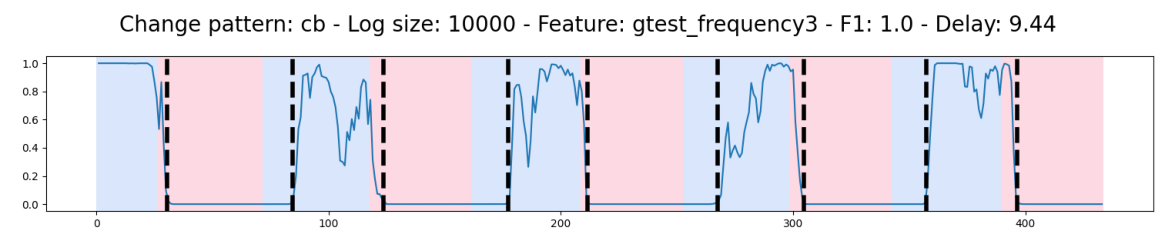

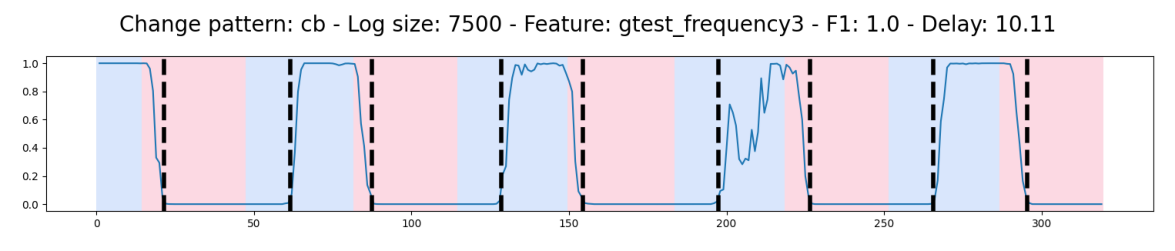

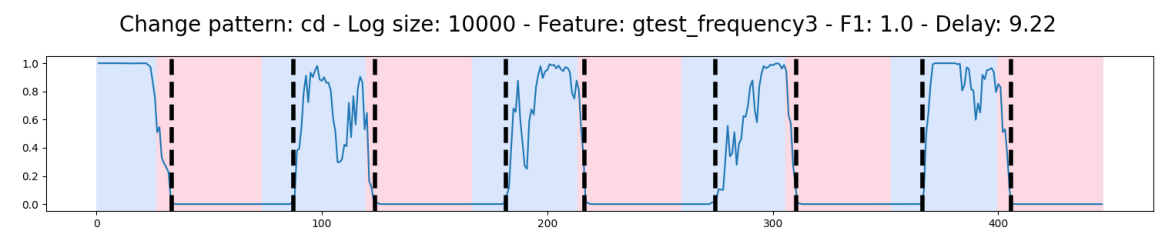

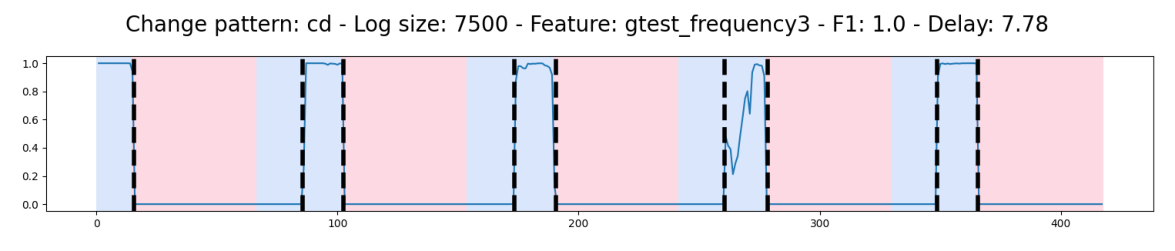

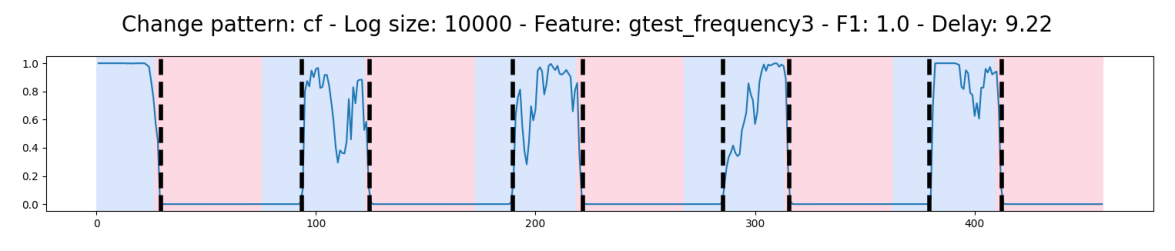

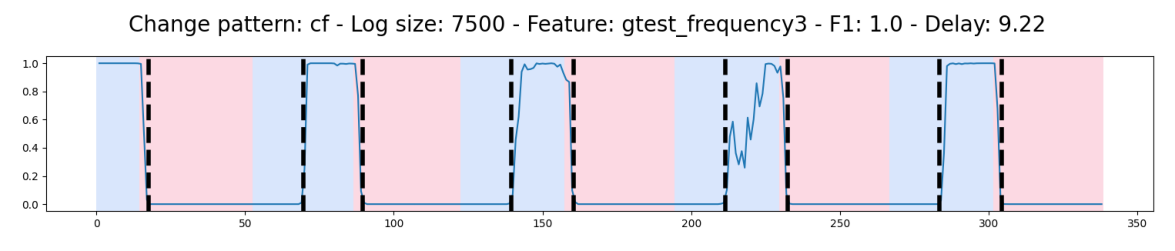

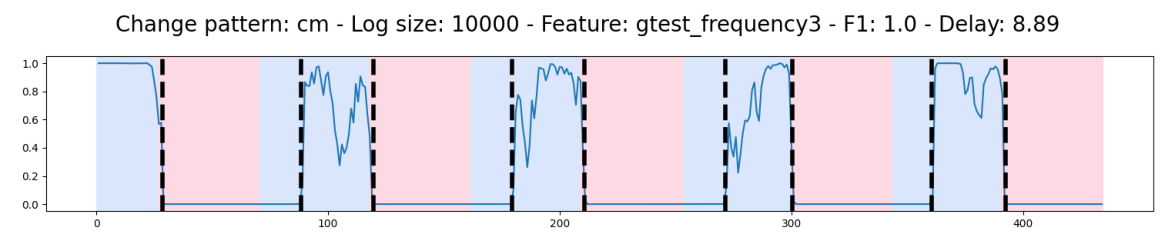

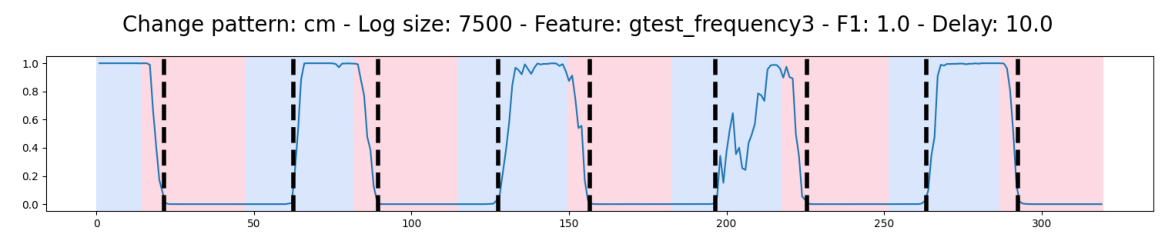

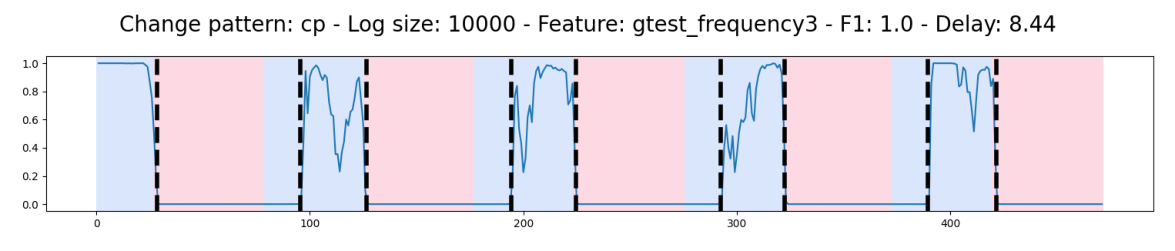

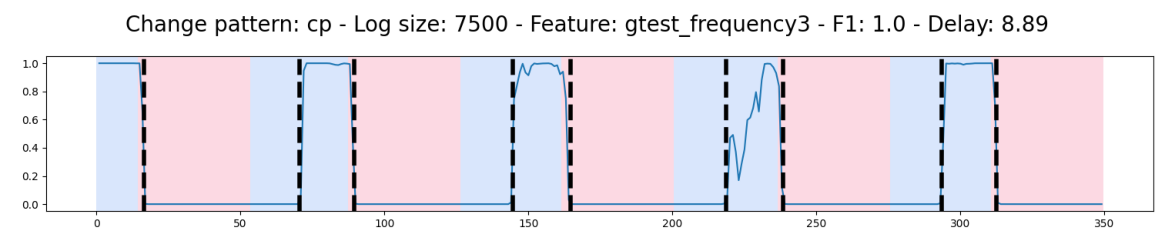

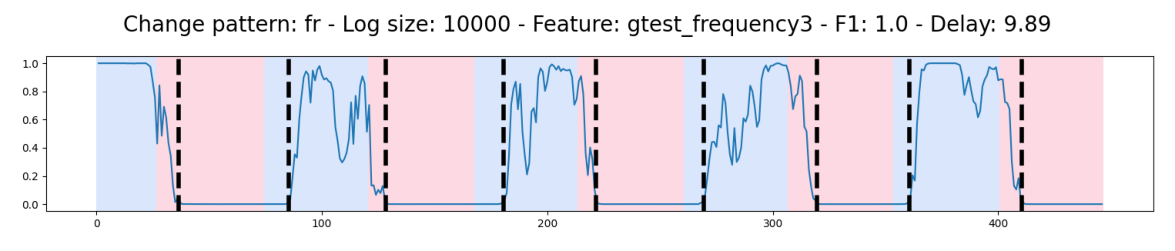

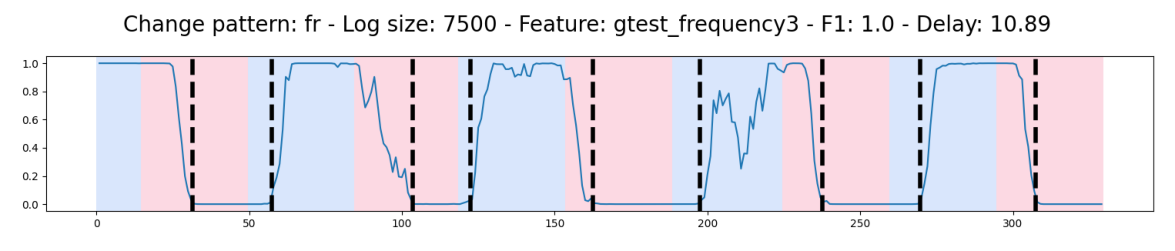

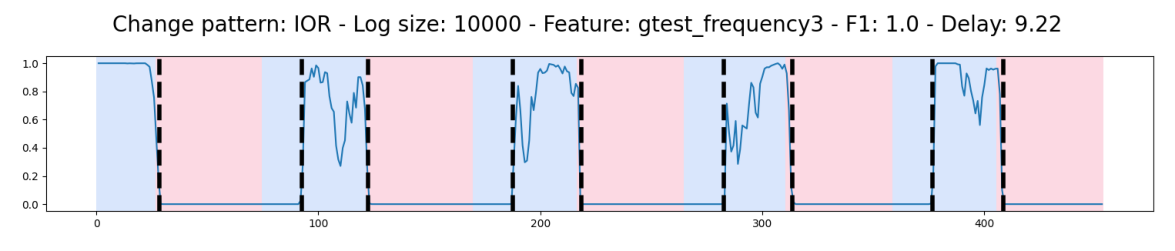

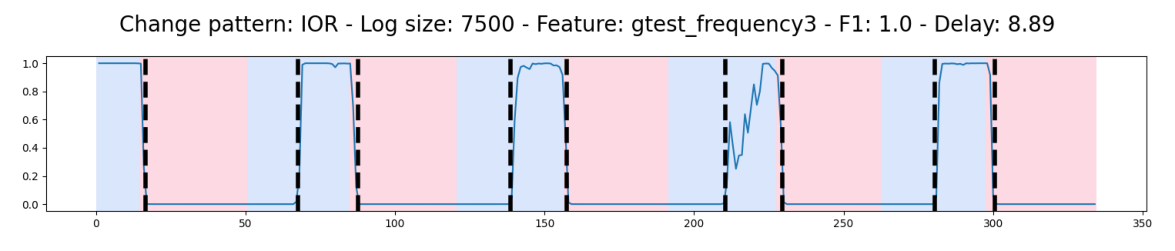

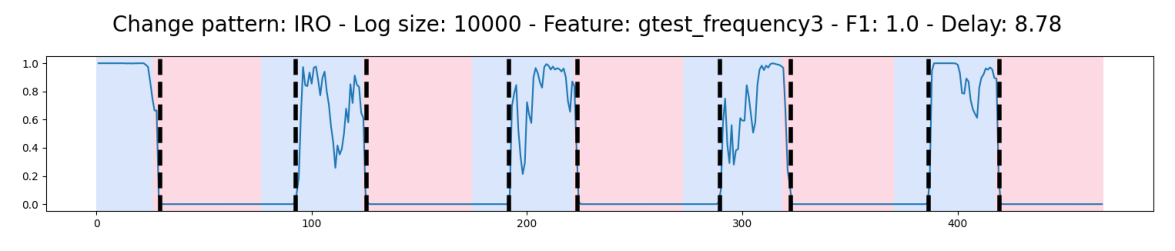

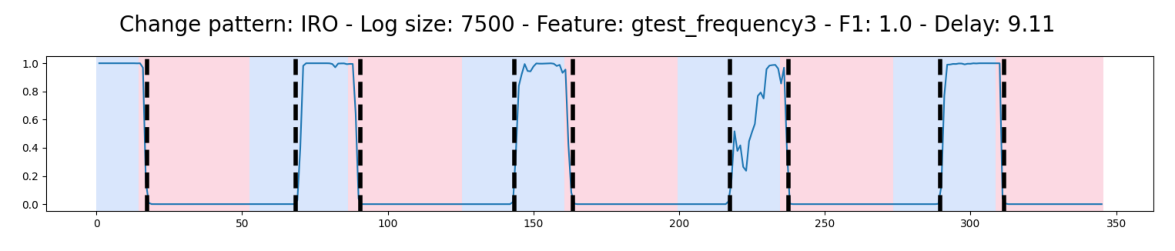

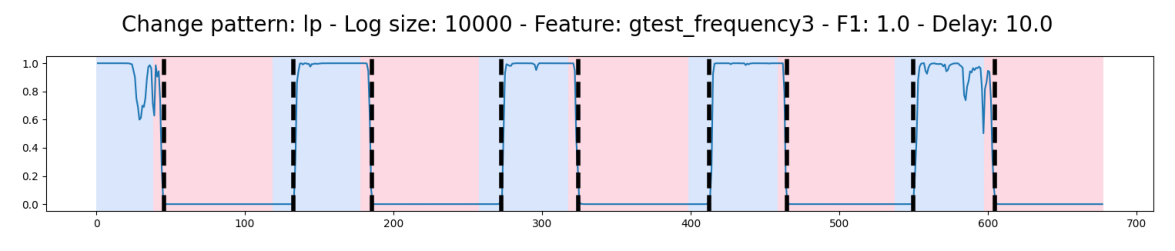

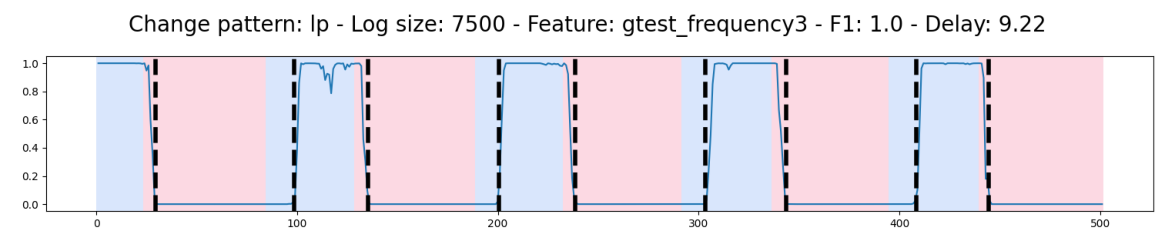

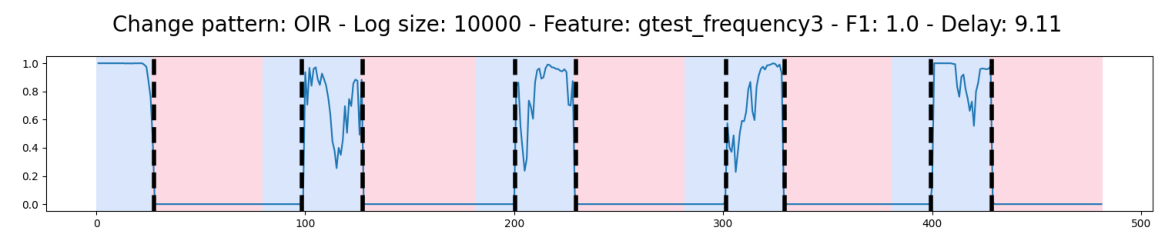

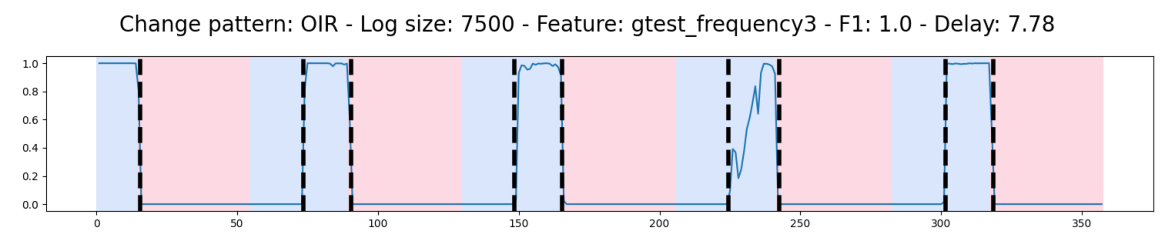

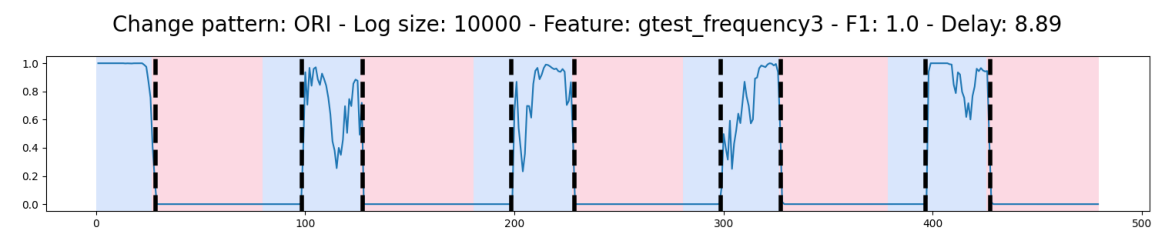

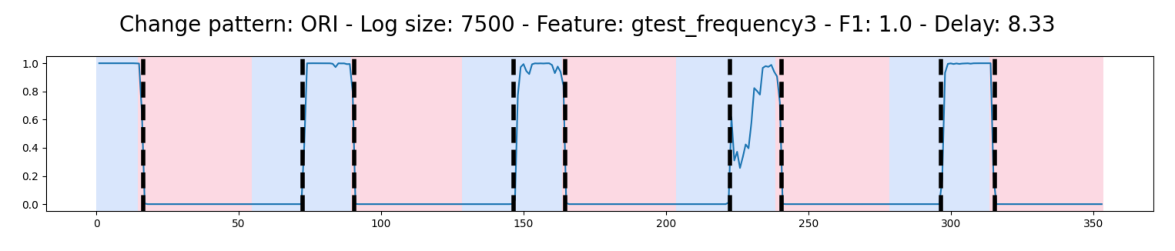

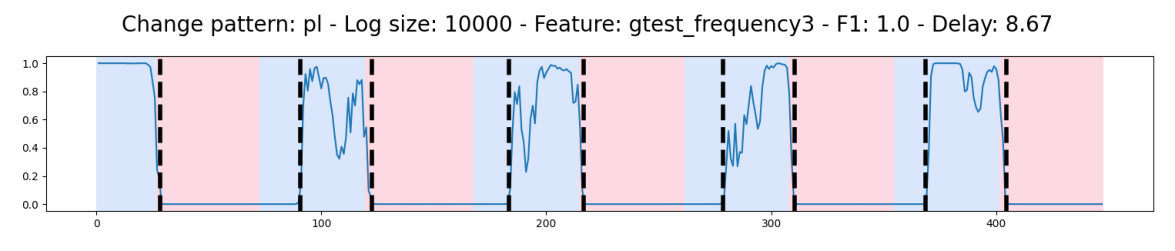

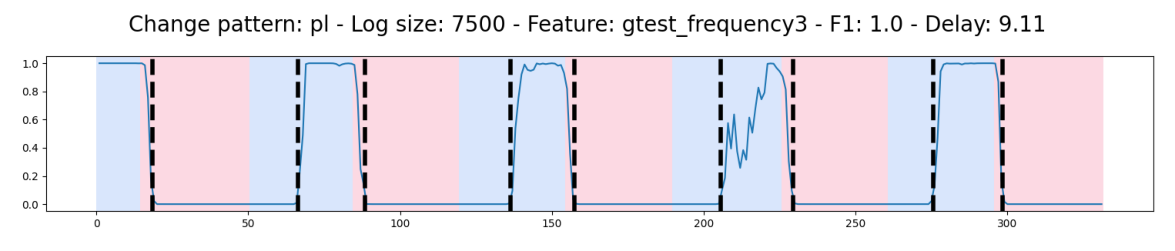

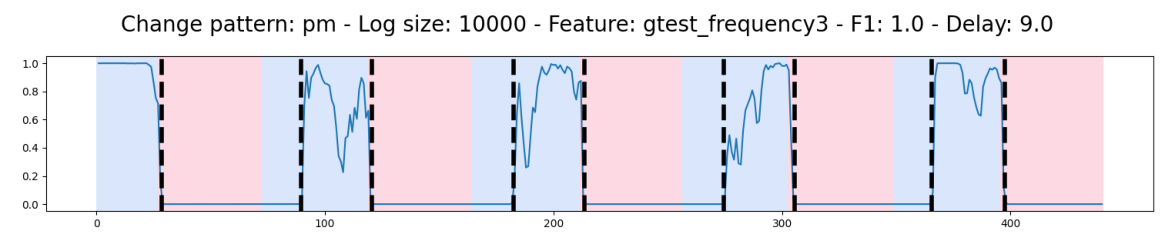

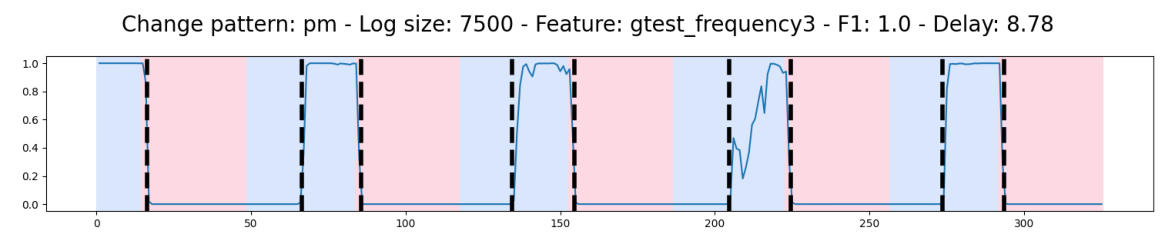

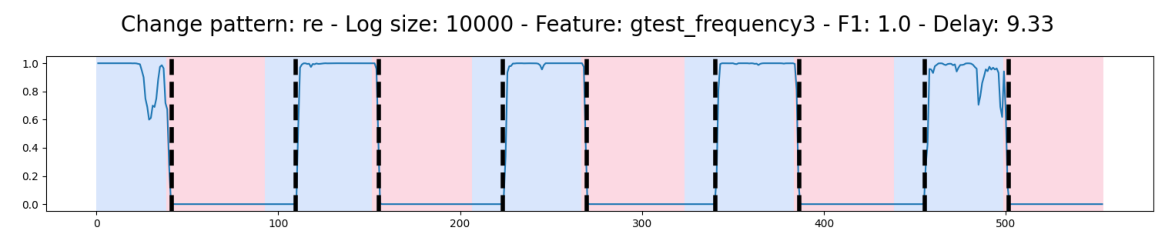

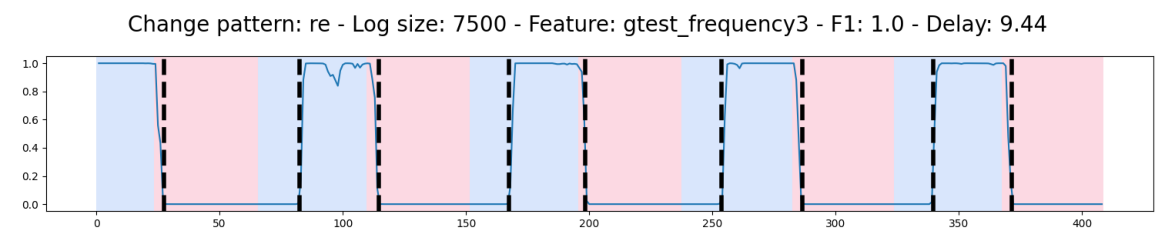

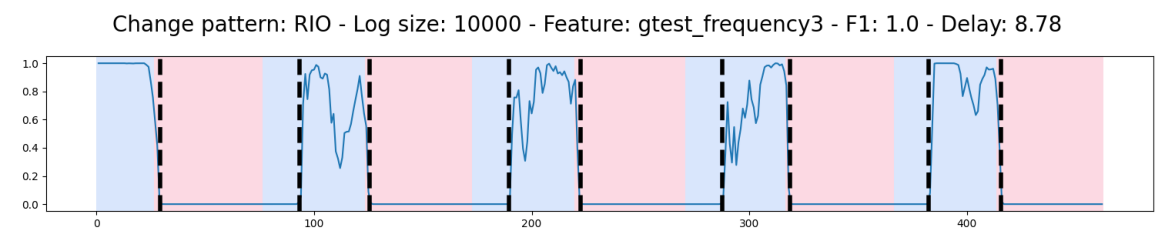

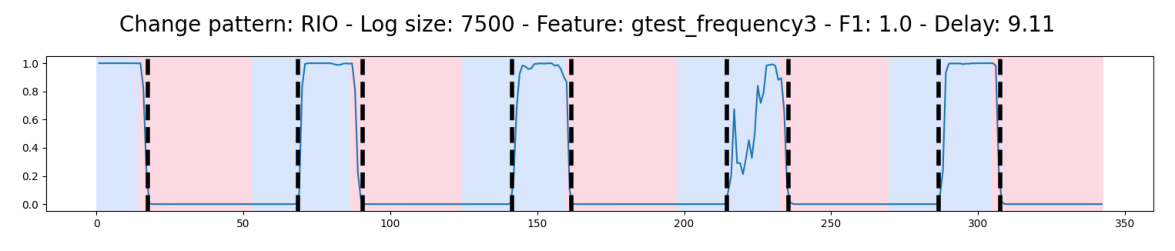

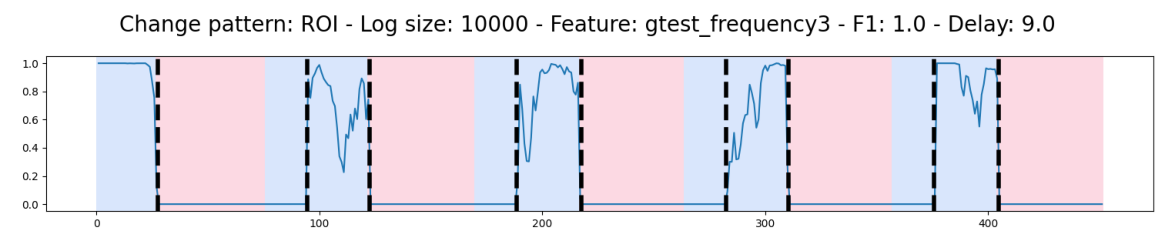

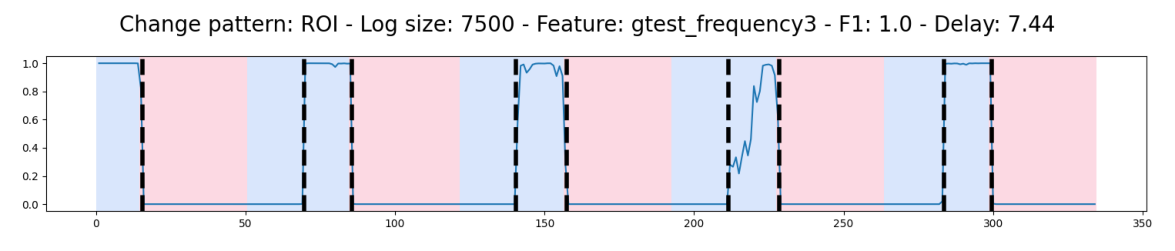

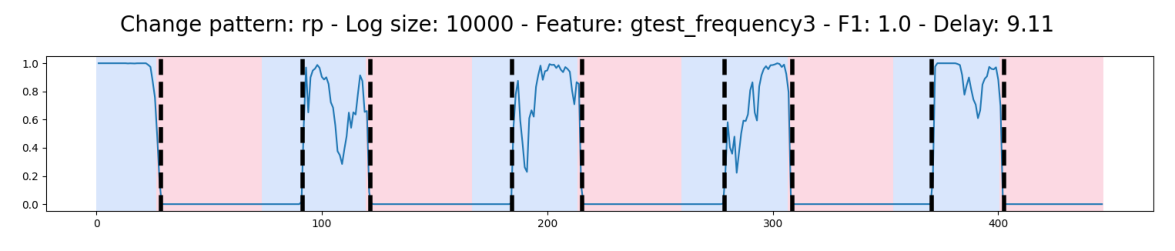

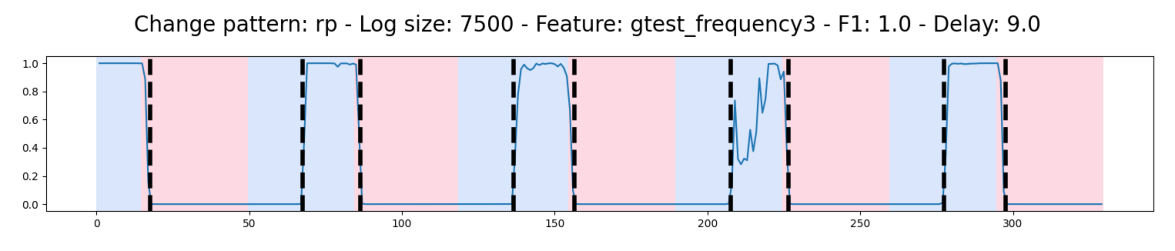

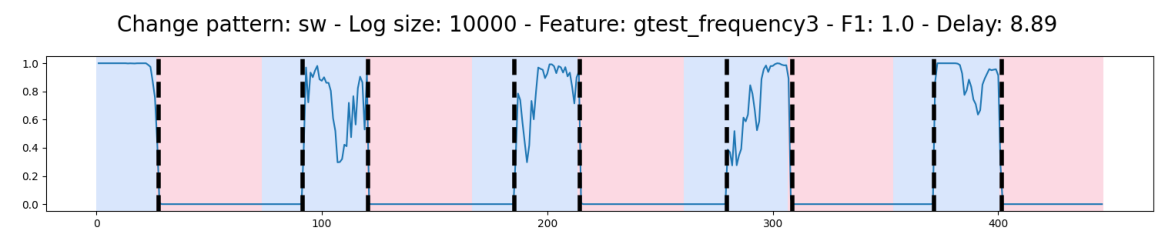

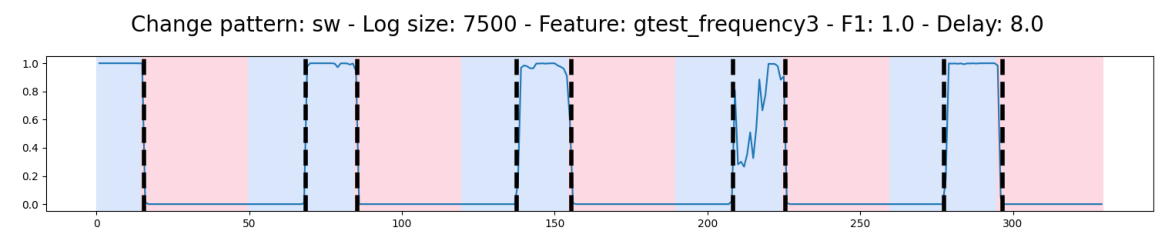

In [15]:
with PdfPages('Results/gtest_frequency3_experiment_Business_Process_Drift.pdf') as pdf:
    for index, result in TMPD_logs_results_experiment_df.iterrows(): 
        fig, ax = plt.subplots(figsize=(15,3))
        plt.axis('off')
        ax.imshow(result['display'])
        pdf.savefig(bbox_inches='tight')
        plt.show()